# **TRAFFIC SIGNS DETECION**

Statistical Methods for Official Statistics

Sapienza University of Rome

Ludovica Mazza, 1917778


## Introduzione

Nel contesto dell'evoluzione della guida autonoma e della sicurezza stradale, il rilevamento accurato e affidabile dei segnali stradali riveste un ruolo cruciale. Questo progetto si propone di affrontare questa sfida impiegando due modelli di machine learning ampiamente riconosciuti e utilizzati: YOLO (You Only Look Once) e MobileNet.


## Obiettivo
Attraverso l'implementazione e la comparazione di YOLO e MobileNet per il rilevamento dei segnali stradali, questo progetto mira a:
- Valutare le prestazioni di entrambi i modelli in termini di precisione, recall e velocità di elaborazione.
- Esplorare le capacità di generalizzazione dei modelli in diverse condizioni ambientali e scenari stradali.
- Identificare le potenziali sfide e limitazioni nell'utilizzo di questi modelli per il rilevamento dei segnali stradali.

Il confronto tra YOLO e MobileNet consentirà di comprendere le loro caratteristiche specifiche e di determinare quale modello si adatta meglio alle esigenze di rilevamento dei segnali stradali.

### Librerie necessarie

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install pybboxes

In [ ]:
import numpy as np
import pandas as pd
import os
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
import pybboxes as pbx
from collections import defaultdict
import shutil
from random import shuffle
import torch
import torchvision.transforms as T
from torchvision.models.detection import fasterrcnn_mobilenet_v3_large_fpn
from PIL import Image, ImageDraw
from torchvision.models.detection import FasterRCNN
from torch import nn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.optim as optim
import matplotlib.patches as patches

### Dataset
Il dataset scelto è un dataset di [kaggle](https://www.kaggle.com/datasets/andrewmvd/road-sign-detection) che contiene 877 scatti della carregiata, e rispettive etichette, in cui vengono inquadrati diversi segnali stradali.

In particolare, i segnali su cui ci concentreremo sono quelli di:
- limiti di velocità
- attraversamento pedonale
- stop
- semafori

NB: Inizialmente, l'intento era utilizzare il dataset GTRSB; tuttavia, la sua dimensione considerevole (60000 immagini) ha reso problematico il suo impiego a causa delle elevate risorse richieste.

Prima di procedere con l'implementazione dei modelli di machine learning, è fondamentale comprendere la natura e la composizione del dataset utilizzato per il rilevamento dei segnali stradali. In questa sezione, esploreremo visivamente il dataset per acquisire una comprensione approfondita delle immagini e delle etichette associate.

In [ ]:
# Seleziono le immagini e le rispettive etichette

image_directory = '/content/drive/MyDrive/SMOS/DATA/data/images'
annotation_directory = '/content/drive/MyDrive/SMOS/DATA/data/annotations'

image_files = [file for file in os.listdir(image_directory) if file.endswith('.png')]
annotation_files = [file for file in os.listdir(annotation_directory) if file.endswith('.xml')]

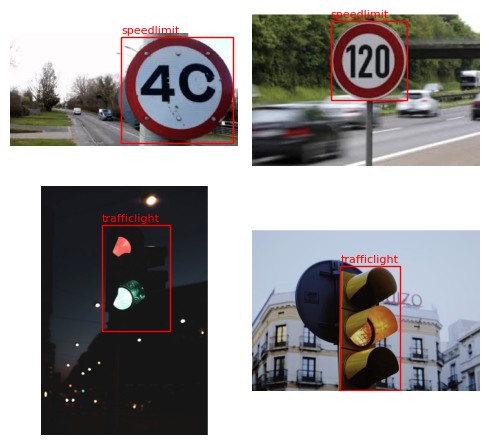

In [ ]:
# Creo una griglia di 2x2 per visualizzare una piccola porzioni delle immagini a disposizione
# e farsi un'idea della tipologia di dati che andremo a trattare.

fig, axs = plt.subplots(2,2, figsize=(5, 5))

for i, img in enumerate(image_files[4:8]):

    image_path = os.path.join(image_directory, img)
    image = Image.open(image_path)
    axs[i // 2, i % 2].imshow(image)
    axs[i // 2, i % 2].axis('off')


    annotation_name = os.path.splitext(img)[0] + '.xml'
    annotation_path = os.path.join(annotation_directory, annotation_name)
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    # Ciclo sulle annotazioni
    for obj in root.findall('object'):
        label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 linewidth=1, edgecolor='r', facecolor='none')
        axs[i // 2, i % 2].add_patch(rect)
        axs[i // 2, i % 2].text(xmin, ymin - 5, label, color='r', fontsize=8)

plt.tight_layout()
plt.show()

### Preprocessing e Transfer Learning

Considerando l'impiego di modelli pre-addestrati tramite transfer learning, non è necessario condurre alcun tipo di preprocessing diretto sulle immagini. L'adozione di modelli già allenati semplifica il processo, poiché permette di sfruttare conoscenze apprese da vasti dataset e applicarle al rilevamento dei segnali stradali senza dover manipolare le immagini del dataset corrente.

Avendo compreso il dataset e considerate le implicazioni del transfer learning, siamo pronti a procedere con l'applicazione dei modelli di machine learning.

Come detto precedentemente, utilizzeremo approcci basati su modelli pre-addestrati per rilevare i segnali stradali di nostro interesse.

### YOLO-v5

In [ ]:
# Controllo se tutti i file sono effettivamente nella cartella corretta

data_path = '/content/drive/MyDrive/SMOS/DATA/data'

for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename))

1. Acquisizione del mdoello pre-addrestrato

In [ ]:
# Per garantire l'utilizzo del modello pre-addestrato, clono la repository GitHub specifica.

# Seleziono la cartella nella quale voglio clonare
os.chdir('/content/drive/MyDrive/SMOS/')

# !git clone https://github.com/ultralytics/yolov5.git

In [ ]:
# Installzione di dipendenze specifiche per garantire il funzionamento corretto del modello

# Specifico la cartella
os.chdir('/content/drive/MyDrive/SMOS/yolov5/')

# !pip install -r requirements.txt

2. Elaborazione delle annotazioni XML relative alle immagini del dataset.

Il codice sotto consente di estrarre le informazioni rilevanti dalle annotazioni XML, organizzarle in un DataFrame e associare un numero univoco a ciascuna classe di segnali stradali per preparare i dati all'addestramento o all'analisi successiva.

In [ ]:
input_path = '/content/drive/MyDrive/SMOS/DATA/data'
output_path = '/content/drive/MyDrive/SMOS/yolov5'

In [ ]:
annotations_path = os.path.join(input_path, 'annotations')
annotations = os.listdir(annotations_path)

In [ ]:
img_name_list = []
width_list = []
height_list = []
label_list = []
xmin_list = []
ymin_list = []
xmax_list = []
ymax_list = []

for idx in tqdm(range(len(annotations))):

    tree = ET.parse(os.path.join(annotations_path, annotations[idx]))
    root = tree.getroot()

    img_name = root.find('filename').text

    size = root.find('size')
    width = size.find('width').text
    height = size.find('height').text

    for group in root.findall('object'):
        label = group.find('name').text
        bbox = group.find('bndbox')
        xmin = bbox.find('xmin').text
        ymin = bbox.find('ymin').text
        xmax = bbox.find('xmax').text
        ymax = bbox.find('ymax').text

        img_name_list.append(img_name)
        width_list.append(width)
        height_list.append(height)
        xmin_list.append(xmin)
        ymin_list.append(ymin)
        xmax_list.append(xmax)
        ymax_list.append(ymax)
        label_list.append(label)

100%|██████████| 877/877 [00:17<00:00, 51.28it/s] 


In [ ]:
labels_df = pd.DataFrame({
                        'img_name': img_name_list,
                        'width': width_list,
                        'height': height_list,
                        'xmin': xmin_list,
                        'ymin': ymin_list,
                        'xmax': xmax_list,
                        'ymax': ymax_list,
                        'label': label_list})
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label
0,road1.png,400,283,154,63,258,281,trafficlight
1,road10.png,400,267,106,3,244,263,trafficlight
2,road0.png,267,400,98,62,208,232,trafficlight
3,road110.png,400,267,196,10,377,181,speedlimit
4,road113.png,400,274,171,38,307,186,speedlimit


In [ ]:
classes = labels_df['label'].unique().tolist()
classes

['trafficlight', 'speedlimit', 'crosswalk', 'stop']

In [ ]:
labels_df['classes'] = labels_df['label'].apply(lambda x: classes.index(x))
labels_df.head()

,img_name,width,height,xmin,ymin,xmax,ymax,label,classes
0,road1.png,400,283,154,63,258,281,trafficlight,0
1,road10.png,400,267,106,3,244,263,trafficlight,0
2,road0.png,267,400,98,62,208,232,trafficlight,0
3,road110.png,400,267,196,10,377,181,speedlimit,1
4,road113.png,400,274,171,38,307,186,speedlimit,1


3. Preparazione delle annotazioni per l'addestramento

In [ ]:
# Genero un dizionario in cui la chiave è il nome dell'immagine e il valore è la lista delle coordinate bbox
# (utilizzate per indicare la posizione e le dimensioni approssimate di un oggetto all'interno di un'immagine)

img_dict = defaultdict(list)

for idx in tqdm(range(len(labels_df))):
    sample_label_list = []
    img_name = labels_df.loc[idx, 'img_name']
    xmin = labels_df.loc[idx, 'xmin']
    ymin = labels_df.loc[idx, 'ymin']
    xmax = labels_df.loc[idx, 'xmax']
    ymax = labels_df.loc[idx, 'ymax']
    class_num = labels_df.loc[idx, 'class']
    W, H = int(labels_df.loc[idx, 'width']), int(labels_df.loc[idx, 'height'])

    voc_bbox = (int(xmin), int(ymin) ,int(xmax), int(ymax))

    x_center, y_center, w, h = pbx.convert_bbox(voc_bbox, from_type="voc", to_type="yolo", image_size=(W,H))

    sample_label_list.append(str(class_num))
    sample_label_list.append(str(x_center))
    sample_label_list.append(str(y_center))
    sample_label_list.append(str(w))
    sample_label_list.append(str(h))
    line = ' '.join(sample_label_list)

    img_dict[img_name].append(line)

100%|██████████| 1244/1244 [00:00<00:00, 1820.90it/s]


In [ ]:
# Creo una cartella dove salvare i labels nel formato corretto

labels_dir = f'{output_path}/data/labels'
if os.path.exists(labels_dir):
    shutil.rmtree(labels_dir)
os.mkdir(labels_dir)

In [ ]:
# Genero un file .txt per ogni imamgine
# Ogni file appare cosi: "0 0.5730337078651685 0.3675 0.41198501872659177 0.425"
# in cui il primo valore (0) rappresenta il nome dell'immagine ("road0") e gli altri quattro sono
# le coordinate bbox

for img_name, lines in img_dict.items():
    img_name = img_name.split('.')[0]
    with open(f'{labels_dir}/{img_name}.txt', 'w') as f:
        for line in lines:
            f.write(line)
            f.write('\n')

4. Train_Test Split

In [ ]:
images_path = input_path + '/images'
labels_path = labels_dir   ## directory having labels in .txt format

In [ ]:
# Creo due sotto cartelle nella cartella "data"
train_dir = output_path + '/data/train'
val_dir = output_path + '/data/val'

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)

os.mkdir(train_dir)
os.mkdir(val_dir)

# In ogni cartella verranno salvate le immagini e i rispettivi labels già convertiti nel giusto formato
os.mkdir(train_dir + '/images')
os.mkdir(train_dir + '/labels')
os.mkdir(val_dir + '/images')
os.mkdir(val_dir + '/labels')

In [ ]:
# Prima di dividere in train e test, faccio lo shuffle delle immagini per garantire che il modello impari in modo più equo
# e rappresentativo, riducendo potenziali bias e migliorando la sua capacità di generalizzazione a dati non visti.

files = os.listdir(images_path)
shuffle(files)

In [ ]:
def split(files, ratio):
    elements = len(files)
    middle = int(elements * ratio)
    return [files[:middle], files[middle:]]

def copy_files(images_path, labels_path, destination_path, files):

    for file_name in files:
        file_name = file_name.split('.')[0]

        src = images_path + f'/{file_name}.png'
        dst = destination_path + '/images'
        shutil.copy(src, dst)

        src = labels_path + f'/{file_name}.txt'
        dst = destination_path + '/labels'
        shutil.copy(src, dst)

In [ ]:
# Divido in 75% train e 25% test e salvo nelle rispettive cartelle

train_ratio = 0.75
train_files, val_files = split(files, train_ratio)

root = 'data/traffic_sign_data'

copy_files(images_path, labels_path, train_dir, train_files)
copy_files(images_path, labels_path, val_dir, val_files)

In [ ]:
# Mi assicuro che la somma delle immagini divise in train e test sia uguale al numero di immagini totali

assert (len(os.listdir(train_dir + '/images')) + len(os.listdir(val_dir + '/images')) == len(os.listdir(images_path)))

In [ ]:
# Creo e popolo un file YAML contenente le informazioni per l'addestramento,
# in particolare: i percorsi delle immagini di addestramento e di validazione, il numero di classi e i nomi delle classi presenti nel dataset.

with open(f'{output_path}/data/sign_data.yaml', 'w') as f:
    f.write('train: ../data/train/images\n')
    f.write('val: ../data/val/images\n')
    f.write('nc: 4\n')
    f.write(f"names: {classes}")

5. Alleno il modello

Avvio l'addestramento di YOLOv5, definendo i seguenti parametri:
- dimensione delle immagini in input
- dimensione del batch
- numero di epoche
- percorsi dei dati
- pesi iniziali del modello pre-addestrato

NB: i risultati sono salvati nella cartella runs/train/exp

In [ ]:
epochs = 20
!python train.py --img 416 --batch 16 --epochs {epochs} --data sign_data.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=sign_data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-240-g84ec8b5 Python-3.10.12 torch-2.1.0+cu118 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translat

6. Visualizzazione dei risultati

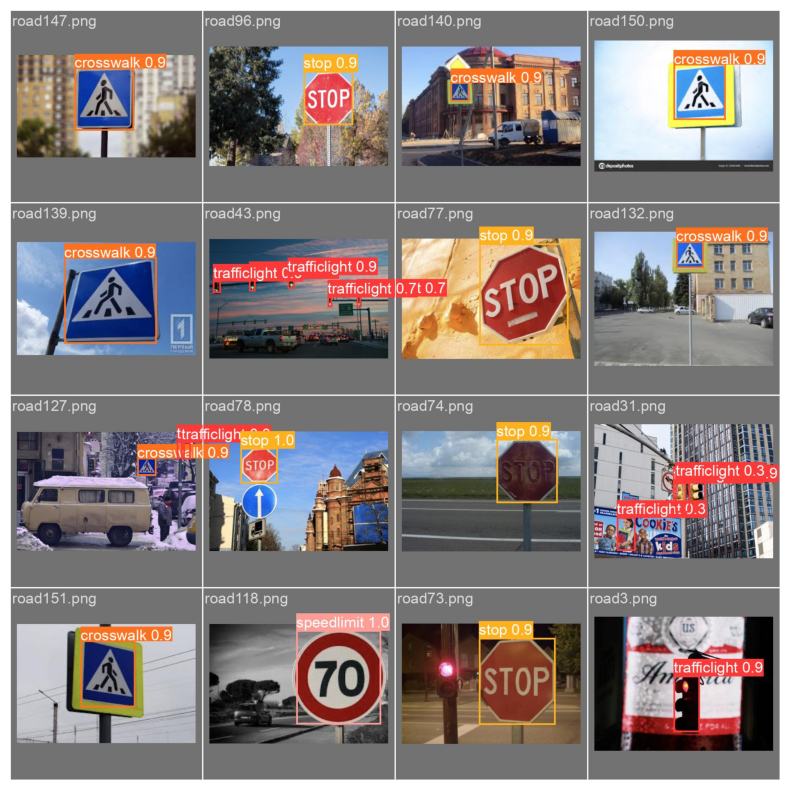

In [ ]:
exp = sorted(os.listdir(output_path + '/runs/train'))[-1]
exp_path = output_path + '/runs/train/' + exp

img_path = exp_path + '/val_batch0_pred.jpg'
img = Image.open(img_path)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.axis('off')
plt.show()

### MobileNet-v3

1. Preparazione del dataset

NB: Per usare MobileNet-v3 userò una versione pre-allenata implementata in pytorch. Questo implica che dovremmo riadattare nuovamente i dati.

In [ ]:
# Definisco una classe per creare il mio dataset personalizzato

class CustomDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        # Estrai le informazioni dalla riga del DataFrame
        xmin = self.dataframe.iloc[idx, 3]
        ymin = self.dataframe.iloc[idx, 4]
        xmax = self.dataframe.iloc[idx, 5]
        ymax = self.dataframe.iloc[idx, 6]
        label = self.dataframe.iloc[idx, 8]

        # Applica le trasformazioni all'immagine e alle coordinate
        if self.transform:
            image = self.transform(image)

        sample = {
            'image': image,
            'xmin': xmin,
            'ymin': ymin,
            'xmax': xmax,
            'ymax': ymax,
            'label': label
        }

        return sample

# Definisco le trasformazioni da applicare a ciascuna immagine prima di essere utilizzate per l'addestramento.
# In questo caso, semplcemente un ridimensionamento di ciascuna immagine + trasformare tutto da array a tensori

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Ad esempio, ridimensiona tutte le immagini a 224x224
    transforms.ToTensor(),
])

In [ ]:
# Creo un'istanza del mio dataset personalizzato
dataset = CustomDataset(dataframe=labels_df, image_dir='/content/drive/MyDrive/SMOS/DATA/data/images', transform=transform)

# Creo un DataLoader generico per facilitare la visualizzazione
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# Visualizziamo la prima istanza del DataLoader per capire come è fatto

for batch in dataloader:
    images = batch['image']
    xmin = batch['xmin']
    ymin = batch['ymin']
    xmax = batch['xmax']
    ymax = batch['ymax']
    labels = batch['label']

    # Visualizza alcune informazioni sul batch
    print("Dimensioni dell'immagine nel batch:", images.size())
    print("Valori di xmin nel batch:", xmin)
    print("Valori di ymin nel batch:", ymin)
    print("Valori di xmax nel batch:", xmax)
    print("Valori di ymax nel batch:", ymax)
    print("Etichette nel batch:", labels)

    # Esce dopo aver stampato il primo batch
    break

Dimensioni dell'immagine nel batch: torch.Size([32, 3, 224, 224])
Valori di xmin nel batch: ['206', '133', '75', '107', '52', '123', '329', '108', '100', '223', '118', '225', '148', '92', '66', '97', '157', '98', '91', '151', '145', '141', '92', '57', '130', '144', '72', '97', '23', '213', '147', '127']
Valori di ymin nel batch: ['261', '164', '74', '196', '29', '200', '127', '106', '133', '92', '202', '170', '71', '273', '155', '172', '25', '170', '115', '319', '161', '181', '153', '154', '146', '232', '155', '132', '6', '324', '196', '170']
Valori di xmax nel batch: ['251', '235', '195', '145', '119', '153', '340', '156', '162', '265', '137', '299', '288', '121', '112', '108', '379', '134', '171', '237', '175', '153', '145', '99', '155', '181', '99', '137', '178', '220', '163', '159']
Valori di ymax nel batch: ['325', '269', '348', '236', '94', '232', '149', '153', '196', '133', '220', '270', '173', '303', '201', '198', '250', '207', '199', '399', '190', '193', '208', '195', '171', '

In [ ]:
# Adesso che ho un'idea di cosa ho nel mio oggett DataLoader, creo due DataLoader separati
# uno per il train e uno per il test

train_df, test_df = train_test_split(labels_df, test_size=0.25, random_state=42)

train_dataset = CustomDataset(dataframe=train_df, image_dir='/content/drive/MyDrive/SMOS/DATA/data/images', transform=transform)
test_dataset = CustomDataset(dataframe=test_df, image_dir='/content/drive/MyDrive/SMOS/DATA/data/images', transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

2. Definisco il modello

In [ ]:
# Creazione di un backbone MobileNetV3 personalizzato

class CustomMobileNetV3LargeFPN(torch.nn.Module):
    def __init__(self):
        super(CustomMobileNetV3LargeFPN, self).__init__()
        self.backbone = fasterrcnn_mobilenet_v3_large_fpn(pretrained=True)
        self.out_channels = 256  # Imposta il numero desiderato di canali di output

    def forward(self, x):
        return self.backbone(x)

# Creo un'istanza del backbone
backbone = CustomMobileNetV3LargeFPN()

# Creo il modello Faster R-CNN con il backbone personalizzato
# NB: personalizzato perchè io ho solo 5 classi (4+background) quindi devo adattare l'ultimo layer

model = FasterRCNN(backbone, num_classes=5)

3. Train

In [ ]:
# Definizione del device su cui addestrare il modello (CPU o GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Definizione della funzione di loss
criterion = detection.fasterrcnn_loss

# Definizione dell'ottimizzatore e del learning rate
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

# Impostazione del modello sul dispositivo corretto
model.to(device)

# Addestramento del modello
num_epochs = 10  # Ad esempio, numero di epoche desiderate
model.train()
for epoch in range(num_epochs):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # Ottieni l'input e le etichette dal dataloader
        inputs, labels = data['image'].to(device), data['label'].to(device)

        # Azzeramento dei gradienti
        optimizer.zero_grad()

        # Esegui l'inoltro (forward)
        outputs = model(inputs)
        loss = criterion(outputs, labels)  # Calcola la loss

        # Backward pass + ottimizzazione
        loss.backward()
        optimizer.step()

        # Stampa le statistiche
        running_loss += loss.item()
        if i % 100 == 99:  # Stampa ogni 100 minibatch
            print(f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 100}')
            running_loss = 0.0

print('Training finished.')

4. Risultati

In [ ]:
img_path = '/content/drive/MyDrive/SMOS/DATA/data/images/road822.png'
img = Image.open(img_path).convert('RGB')
new_size = (500, 500)
width_percent = (new_size[0] / float(img.size[0]))
height_size = int((float(img.size[1]) * float(width_percent)))
resized_img = img.resize((new_size[0], height_size))

transform = T.Compose([T.ToTensor()])
img_tensor = transform(img)
img_tensor = img_tensor.unsqueeze(0)

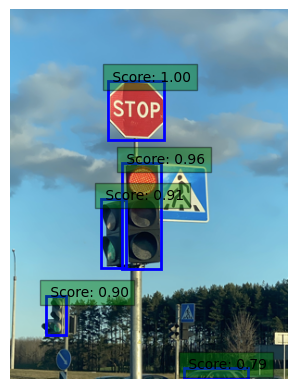

In [ ]:
fig, ax = plt.subplots(1)
ax.imshow(img)

for score, label, box in zip(predictions[0]['scores'], predictions[0]['labels'], predictions[0]['boxes']):
    if score > 0.5:  # Imposta una soglia di confidenza
        box = [int(i) for i in box]
        rect = plt.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1], linewidth=2, edgecolor='b', facecolor='none')
        ax.add_patch(rect)
        ax.text(box[0], box[1], f" Score: {score:.2f}", bbox=dict(facecolor='green', alpha=0.4))
plt.axis('off')
plt.show()